# Imports

In [1]:
!pip install ffmpeg-python

In [1]:
import sys, subprocess, importlib
pkgs = ['torch', 'torchvision', 'numpy', 'opencv_python', 'tqdm', 'matplotlib']
missing = []
for p in pkgs:
    try:
        importlib.import_module(p)
    except Exception:
        missing.append(p)

if missing:
    print('Missing packages:', missing)
    print('Installing missing packages into the current Python environment. This may take a few minutes.')
    cmd = [sys.executable, '-m', 'pip', 'install'] + missing
    subprocess.check_call(cmd)
else:
    print('All minimal packages present')


import os
import traceback
from pathlib import Path
import torch
import torchvision
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F


from fsgan.utils.utils import load_model
from fsgan.utils import img_utils, landmarks_utils
from fsgan.models.hrnet import hrnet_wlfw
from fsgan.inference import swap as swap_mod

from fsgan.notebook_helpers.reenact_preprocess import run_full_pipeline

import traceback
from pathlib import Path


ROOT = Path('.')
WEIGHTS_DIR = ROOT / 'fsgan' / 'weights'
OUT_DIR = ROOT / 'outputs'
OUT_DIR.mkdir(exist_ok=True)
IMG_A = ROOT / 'j.jpg'
IMG_J = ROOT / 'a.jpg'
print('Weights directory:', WEIGHTS_DIR)
print('Expecting images at:', IMG_A, IMG_J)
print('Outputs will be saved to:', OUT_DIR)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device', device)

def load_image_as_tensor(p, size=256, device=None):
    im = cv2.imread(str(p))
    if im is None:
        raise FileNotFoundError(f'Image not found: {p}')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (size, size), interpolation=cv2.INTER_AREA)
    im = im.astype('float32') / 255.0
    t = torch.from_numpy(im.transpose(2,0,1)).unsqueeze(0)
    if device is not None:
        t = t.to(device)
    return t

def read_bgr_tensor(p, device=device, size=256):
    im = cv2.imread(str(p))
    if im is None:
        raise FileNotFoundError(f'Image not found: {p}')
    if size is not None:
        im = cv2.resize(im, (size, size), interpolation=cv2.INTER_AREA)
    return img_utils.bgr2tensor(im, normalize=False).to(device)

def save_mask(mask, outpath):
    cv2.imwrite(str(outpath), mask)

print('Top-level imports and helpers are ready')

Missing packages: ['opencv_python']
Installing missing packages into the current Python environment. This may take a few minutes.
Weights directory: fsgan\weights
Expecting images at: j.jpg a.jpg
Outputs will be saved to: outputs
Using device cuda:0
Top-level imports and helpers are ready
Weights directory: fsgan\weights
Expecting images at: j.jpg a.jpg
Outputs will be saved to: outputs
Using device cuda:0
Top-level imports and helpers are ready


# Segmentation

In [3]:

seg_w = WEIGHTS_DIR / 'celeba_unet_256_1_2_segmentation_v2.pth'
out_seg_dir = OUT_DIR / 'segmentation'
out_seg_dir.mkdir(exist_ok=True)
try:
    model_seg = load_model(str(seg_w), 'segmentation', device=device)
    model_seg.eval()
    t = load_image_as_tensor(IMG_A, size=256, device=device)
    with torch.no_grad():
        pred = model_seg(t)

    pred_np = pred.detach().cpu().numpy()
    if pred_np.ndim == 4:
        mask = pred_np.argmax(1)[0].astype('uint8') * 85 
    else:

        mask = (pred_np[0,0] * 255).astype('uint8')
    out_path = out_seg_dir / 'a_seg_mask.png'
    save_mask(mask, out_path)
    print('Segmentation saved to', out_path)
except Exception as e:
    print('Segmentation test failed:', e)
    traceback.print_exc()

=> Loading segmentation model: "celeba_unet_256_1_2_segmentation_v2.pth"...
Segmentation test failed: Image not found: j.jpg


Traceback (most recent call last):
  File "C:\Users\Arthur\AppData\Local\Temp\ipykernel_9404\2035386436.py", line 7, in <module>
    t = load_image_as_tensor(IMG_A, size=256, device=device)
  File "C:\Users\Arthur\AppData\Local\Temp\ipykernel_9404\234215183.py", line 58, in load_image_as_tensor
    raise FileNotFoundError(f'Image not found: {p}')
FileNotFoundError: Image not found: j.jpg


# Landmarks

In [4]:

lms_w = WEIGHTS_DIR / 'hr18_wflw_landmarks.pth'
out_lms_dir = OUT_DIR / 'landmarks'
out_lms_dir.mkdir(exist_ok=True)
try:
    model_lms = load_model(str(lms_w), 'landmarks', device=device)
    model_lms.eval()
    t = load_image_as_tensor(IMG_A, size=256, device=device)
    with torch.no_grad():
        out = model_lms(t)
    print('Landmarks model forward output shape:', getattr(out, 'shape', None))

    try:
        out_np = out.detach().cpu().numpy()
        if out_np.ndim == 4:
            hm = out_np[0,0]
            hm = (255 * (hm - hm.min()) / (hm.max() - hm.min() + 1e-8)).astype('uint8')
            cv2.imwrite(str(out_lms_dir / 'a_landmark_heatmap_ch0.png'), hm)
            print('Saved example landmark heatmap to', out_lms_dir / 'a_landmark_heatmap_ch0.png')
    except Exception as e:
        print('Could not save landmark heatmap:', e)
except Exception as e:
    print('Landmarks test failed:', e)
    traceback.print_exc()

=> Loading landmarks model: "hr18_wflw_landmarks.pth"...
Landmarks test failed: Image not found: j.jpg


Traceback (most recent call last):
  File "C:\Users\Arthur\AppData\Local\Temp\ipykernel_9404\2682333012.py", line 7, in <module>
    t = load_image_as_tensor(IMG_A, size=256, device=device)
  File "C:\Users\Arthur\AppData\Local\Temp\ipykernel_9404\234215183.py", line 58, in load_image_as_tensor
    raise FileNotFoundError(f'Image not found: {p}')
FileNotFoundError: Image not found: j.jpg


In [5]:


reenact_w = ROOT / 'fsgan' / 'weights' / 'nfv_msrunet_256_1_2_reenactment_v2.1.pth'
lms_w = ROOT / 'fsgan' / 'weights' / 'hr18_wflw_landmarks.pth'
src_path = ROOT / 'input/a.jpg'
tgt_path = ROOT / 'input/j.jpg'
out_path = ROOT / 'outputs' / 'reenact_a_to_j.png'
out_path.parent.mkdir(parents=True, exist_ok=True)

print('Device:', device)
print('Reenact model:', reenact_w)
print('Landmarks model:', lms_w)
print('Source:', src_path, 'Target:', tgt_path)

# load reenactment generator
try:
    Gr, ckpt = load_model(str(reenact_w), 'reenactment', device=device, return_checkpoint=True)
    Gr.eval()
    try:
        print('Checkpoint arch:', ckpt.get('arch', None))
    except Exception:
        pass
except Exception as e:
    print('Failed loading reenactment model:', e)
    traceback.print_exc()
    raise

# load landmarks model
try:
    L = None
    try:
        L = load_model(str(lms_w), 'landmarks', device=device)
        print('Loaded landmarks using utils.load_model()')
    except AssertionError:
        print('Landmarks file looks like raw state_dict, falling back to hrnet factory')
    if L is None:
        L = hrnet_wlfw().to(device)
        state_dict = torch.load(str(lms_w), map_location=device)
        L.load_state_dict(state_dict)
    L.eval()
except Exception as e:
    print('Failed loading landmarks model:', e)
    traceback.print_exc()
    raise


base_res = 256
try:
    src_t = read_bgr_tensor(src_path, device=device, size=base_res)
    tgt_t = read_bgr_tensor(tgt_path, device=device, size=base_res)
except Exception as e:
    print('Image loading error:', e)
    raise


try:
    n_local = getattr(Gr, 'n_local_enhancers', None)
    if n_local is None and hasattr(Gr, 'module'):
        n_local = getattr(Gr.module, 'n_local_enhancers', None)
    if n_local is None:
        n_local = 1
    required_levels = int(n_local) + 1
    print('Generator n_local_enhancers =', n_local, '; building pyramid with', required_levels, 'levels')
except Exception as e:
    print('Could not determine generator n_local_enhancers:', e)
    required_levels = 3

src_pyd = img_utils.create_pyramid(src_t, n=required_levels)


with torch.no_grad():
    tgt_for_lms = (tgt_t - torch.as_tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)) / torch.as_tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)
    context = L(tgt_for_lms)
    context = landmarks_utils.filter_landmarks(context)

for i in range(len(src_pyd)):
    src_pyd[i] = (src_pyd[i] - torch.as_tensor([0.5,0.5,0.5], device=device).view(1,3,1,1)) / torch.as_tensor([0.5,0.5,0.5], device=device).view(1,3,1,1)


inp = []
for p in range(len(src_pyd)-1, -1, -1):
    c = torch.nn.functional.interpolate(context, size=src_pyd[p].shape[2:], mode='bicubic', align_corners=False)
    inp.insert(0, torch.cat((src_pyd[p], c), dim=1))

with torch.no_grad():
    reenact_img = Gr(inp)

out_tensor = reenact_img[-1] if isinstance(reenact_img, (list, tuple)) else reenact_img
out_bgr = img_utils.tensor2bgr(out_tensor[0].cpu())
cv2.imwrite(str(out_path), out_bgr)
print('Saved reenactment to:', out_path)


Device: cuda:0
Reenact model: fsgan\weights\nfv_msrunet_256_1_2_reenactment_v2.1.pth
Landmarks model: fsgan\weights\hr18_wflw_landmarks.pth
Source: input\a.jpg Target: input\j.jpg
=> Loading reenactment model: "nfv_msrunet_256_1_2_reenactment_v2.1.pth"...
Checkpoint arch: res_unet.MultiScaleResUNet(in_nc=101,out_nc=3,flat_layers=(2,2,2,2),ngf=128)
=> Loading landmarks model: "hr18_wflw_landmarks.pth"...
Loaded landmarks using utils.load_model()
Generator n_local_enhancers = 1 ; building pyramid with 2 levels
Saved reenactment to: outputs\reenact_a_to_j.png


# Reenactment Analysis & Debug

Let's understand why the reenactment quality is poor. The FSGAN paper describes:

1. **Generator input**: Source image (3ch) + Target landmarks heatmap (98ch) = 101 channels
2. **Landmarks processing**: The HRNet outputs heatmaps that need `filter_landmarks` to threshold activations
3. **Multi-scale pyramid**: Generator uses coarse-to-fine processing with local enhancers
4. **Face view interpolation**: For large pose differences, multiple source views are interpolated (Section 3.3)

Key issues to check:
- Is the landmarks context being computed from the **target** image?
- Are normalizations correct ([-1,1] for generator, ImageNet for landmarks model)?
- Does the landmark heatmap have the right number of channels (98)?

In [6]:
# Improved Reenactment - Debug & Visualization
# This cell reproduces the FSGAN preprocessing more faithfully

from fsgan.utils.landmarks_utils import LandmarksHeatMapDecoder, filter_landmarks
from fsgan.utils.img_utils import bgr2tensor, create_pyramid, tensor2bgr
from fsgan.utils.bbox_utils import get_main_bbox, crop_img

# Paths
reenact_w = ROOT / 'fsgan' / 'weights' / 'nfv_msrunet_256_1_2_reenactment_v2.1.pth'
lms_w = ROOT / 'fsgan' / 'weights' / 'hr18_wflw_landmarks.pth'
src_path = str(ROOT / 'input/tim.jpg')
tgt_path = str(ROOT / 'input/tim.jpg')

resolution = 256
crop_scale = 1.2

# Load models
print("Loading reenactment generator...")
Gr, ckpt = load_model(str(reenact_w), 'reenactment', device=device, return_checkpoint=True)
Gr.eval()
print(f"Generator architecture: {ckpt.get('arch', 'unknown')}")

# Check generator properties
n_local = getattr(Gr, 'n_local_enhancers', None)
if n_local is None and hasattr(Gr, 'module'):
    n_local = getattr(Gr.module, 'n_local_enhancers', None)
n_local = n_local if n_local is not None else 1
n_levels = n_local + 1
print(f"Generator n_local_enhancers: {n_local}, pyramid levels: {n_levels}")

print("Loading landmarks model...")
L, _ = load_model(str(lms_w), 'landmarks', device=device, return_checkpoint=True)
L.eval()

# Initialize landmarks decoder for each pyramid level
# The decoder converts (B, 98, 2) points -> (B, 98, H, W) heatmaps
# But HRNet outputs heatmaps directly, so we just use filter_landmarks
landmarks_decoders = []
for res in [128, 256]:  # Coarse to fine
    landmarks_decoders.insert(0, LandmarksHeatMapDecoder(res).to(device))
print(f"Initialized {len(landmarks_decoders)} landmarks decoders")

# Read and preprocess images
print(f"\nReading images: {src_path}, {tgt_path}")
src_bgr = cv2.imread(src_path)
tgt_bgr = cv2.imread(tgt_path)
assert src_bgr is not None and tgt_bgr is not None, "Failed to read images"

def preprocess_for_reenactment(img_bgr, resolution=256, crop_scale=1.0):
    """Preprocess image: center crop and resize."""
    h, w = img_bgr.shape[:2]
    # Simple center crop (fallback when no detector)
    size = int(min(h, w) * 0.8)
    left = (w - size) // 2
    top = (h - size) // 2
    
    # Apply crop scale
    cx, cy = left + size/2, top + size/2
    new_size = int(size * crop_scale)
    left = int(cx - new_size/2)
    top = int(cy - new_size/2)
    
    # Crop with border replication
    bbox = np.array([left, top, new_size, new_size], dtype=int)
    cropped = crop_img(img_bgr, bbox, border=cv2.BORDER_REPLICATE)
    cropped = cv2.resize(cropped, (resolution, resolution), interpolation=cv2.INTER_CUBIC)
    return cropped

src_crop = preprocess_for_reenactment(src_bgr, resolution, crop_scale)
tgt_crop = preprocess_for_reenactment(tgt_bgr, resolution, crop_scale)

print(f"Cropped source shape: {src_crop.shape}, target shape: {tgt_crop.shape}")

# Convert to tensors with correct normalizations
# Generator expects [-1, 1]
src_tensor = bgr2tensor(src_crop, normalize=True).to(device)  # [-1, 1]
tgt_tensor = bgr2tensor(tgt_crop, normalize=True).to(device)  # [-1, 1]
print(f"Source tensor range: [{src_tensor.min():.2f}, {src_tensor.max():.2f}]")

# Landmarks model expects ImageNet normalization
imagenet_mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
imagenet_std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

# Convert BGR crop to RGB tensor with ImageNet normalization for landmarks
tgt_rgb = tgt_crop[:, :, ::-1].copy()  # BGR -> RGB
tgt_for_lms = torch.from_numpy(tgt_rgb.transpose(2, 0, 1)).float().div_(255.0).unsqueeze(0).to(device)
tgt_for_lms = (tgt_for_lms - imagenet_mean) / imagenet_std
print(f"Target for landmarks range: [{tgt_for_lms.min():.2f}, {tgt_for_lms.max():.2f}]")

# Get landmarks heatmap from target
with torch.no_grad():
    tgt_landmarks = L(tgt_for_lms)
print(f"Raw landmarks output shape: {tgt_landmarks.shape}")

# The HRNet outputs heatmaps, filter them
tgt_landmarks_filtered = filter_landmarks(tgt_landmarks)
print(f"Filtered landmarks shape: {tgt_landmarks_filtered.shape}, range: [{tgt_landmarks_filtered.min():.2f}, {tgt_landmarks_filtered.max():.2f}]")

# Build source image pyramid
src_pyd = create_pyramid(src_tensor, n_levels)
print(f"Source pyramid: {[p.shape for p in src_pyd]}")

# Build input: source image + target landmarks context at each pyramid level
input_list = []
for p in range(len(src_pyd)):
    # Resize landmarks to match pyramid level
    pyd_h, pyd_w = src_pyd[p].shape[2:]
    context = F.interpolate(tgt_landmarks_filtered, size=(pyd_h, pyd_w), mode='bilinear', align_corners=False)
    context = filter_landmarks(context)  # Re-filter after interpolation
    
    # Concatenate: [source_image (3ch), target_landmarks (98ch)]
    inp = torch.cat((src_pyd[p], context), dim=1)
    input_list.append(inp)
    print(f"Pyramid level {p}: input shape {inp.shape} (3 img + {context.shape[1]} landmarks)")

# Run reenactment generator
print("\nRunning reenactment generator...")
with torch.no_grad():
    output = Gr(input_list)

# Handle output (could be tensor or list)
if isinstance(output, (list, tuple)):
    out_tensor = output[-1]
    print(f"Generator returned list with {len(output)} items")
else:
    out_tensor = output
print(f"Output tensor shape: {out_tensor.shape}, range: [{out_tensor.min():.2f}, {out_tensor.max():.2f}]")

# Convert to image
out_bgr = tensor2bgr(out_tensor[0].cpu())
out_path = str(OUT_DIR / 'reenact_debug.png')
cv2.imwrite(out_path, out_bgr)
print(f"\nSaved output to: {out_path}")

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(src_crop[:, :, ::-1]); axes[0].set_title('Source (identity)')
axes[1].imshow(tgt_crop[:, :, ::-1]); axes[1].set_title('Target (pose/expression)')
axes[2].imshow(out_bgr[:, :, ::-1]); axes[2].set_title('Reenacted')

# Show landmarks heatmap (sum of all channels)
lms_vis = tgt_landmarks_filtered[0].sum(0).cpu().numpy()
axes[3].imshow(lms_vis, cmap='hot'); axes[3].set_title('Target landmarks heatmap')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

Loading reenactment generator...
=> Loading reenactment model: "nfv_msrunet_256_1_2_reenactment_v2.1.pth"...
Generator architecture: res_unet.MultiScaleResUNet(in_nc=101,out_nc=3,flat_layers=(2,2,2,2),ngf=128)
Generator n_local_enhancers: 1, pyramid levels: 2
Loading landmarks model...
=> Loading landmarks model: "hr18_wflw_landmarks.pth"...


c:\Users\Arthur\Documents\Github\Face-Swap-M2\.venv\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Initialized 2 landmarks decoders

Reading images: input\tim.jpg, input\tim.jpg
Cropped source shape: (256, 256, 3), target shape: (256, 256, 3)
Source tensor range: [-0.87, 0.67]
Target for landmarks range: [-1.84, 1.87]
Raw landmarks output shape: torch.Size([1, 98, 64, 64])
Filtered landmarks shape: torch.Size([1, 98, 64, 64]), range: [0.00, 1.00]
Source pyramid: [torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 128, 128])]
Pyramid level 0: input shape torch.Size([1, 101, 256, 256]) (3 img + 98 landmarks)
Pyramid level 1: input shape torch.Size([1, 101, 128, 128]) (3 img + 98 landmarks)

Running reenactment generator...
Output tensor shape: torch.Size([1, 3, 256, 256]), range: [-0.86, 0.79]

Saved output to: outputs\reenact_debug.png


C:\Users\Arthur\AppData\Local\Temp\ipykernel_9404\1810110158.py:148: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# Key Differences from Paper

If results are still poor, here are the main reasons based on the paper:

## 1. Face View Interpolation (Section 3.3)
The paper states: *"Following others, training subject agnostic face reenactment models is inherently limited to handle unseen face images related by large poses. To address this challenge, we propose to break large pose changes into small manageable steps and interpolate between the closest available source images corresponding to a target's pose."*

For **single image pairs** with very different poses, the model struggles because:
- It was trained on video sequences where pose changes are gradual
- The appearance map provides multiple source views to interpolate

## 2. Stepwise Reenactment (Training with Lrec)
From the paper's loss (Eq. 7): The model uses a **stepwise loss** that applies reenactment iteratively through intermediate poses. This is critical for large pose differences.

## 3. Recommendations for Better Results

1. **Use images with similar head poses** - The model works best when source and target have similar yaw/pitch
2. **Use video input** - The appearance map mechanism requires multiple source frames
3. **Fine-tune on subject** - The paper mentions per-subject finetuning for best results
4. **Check face detection** - Ensure faces are properly centered and cropped

In [7]:
# Check what the generator architecture expects
# Let's inspect the model to understand input/output expectations

print("=" * 60)
print("GENERATOR ARCHITECTURE ANALYSIS")
print("=" * 60)

# Get actual model (handle DataParallel wrapper)
model = Gr.module if hasattr(Gr, 'module') else Gr

print(f"\nModel type: {type(model).__name__}")
print(f"Model class: {model.__class__.__name__}")

# Check for key attributes
attrs_to_check = ['n_local_enhancers', 'in_nc', 'out_nc', 'ngf', 'n_blocks']
for attr in attrs_to_check:
    val = getattr(model, attr, 'N/A')
    print(f"  {attr}: {val}")

# Try to find input channels from first layer
try:
    first_conv = None
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            first_conv = module
            break
    if first_conv:
        print(f"\nFirst Conv2d layer:")
        print(f"  in_channels: {first_conv.in_channels}")
        print(f"  out_channels: {first_conv.out_channels}")
        print(f"  kernel_size: {first_conv.kernel_size}")
except Exception as e:
    print(f"Could not inspect layers: {e}")

# Verify checkpoint info
print(f"\nCheckpoint keys: {list(ckpt.keys())}")
if 'arch' in ckpt:
    print(f"Architecture string: {ckpt['arch']}")

# Check landmarks model output
print("\n" + "=" * 60)
print("LANDMARKS MODEL ANALYSIS")
print("=" * 60)

lms_model = L.module if hasattr(L, 'module') else L
print(f"Landmarks model type: {type(lms_model).__name__}")

# Test forward pass to verify output shape
test_input = torch.randn(1, 3, 256, 256, device=device)
with torch.no_grad():
    test_lms = L(test_input)
print(f"Test output shape: {test_lms.shape}")
print(f"Expected for 98-point WFLW: (1, 98, H, W) where H=W=64 typically")

# Verify the landmark output is heatmaps, not points
if test_lms.dim() == 4:
    print("✓ Output is 4D (heatmaps)")
elif test_lms.dim() == 3 and test_lms.shape[-1] == 2:
    print("✓ Output is 3D points (B, N, 2)")
else:
    print(f"⚠ Unexpected output dimensionality: {test_lms.dim()}")

GENERATOR ARCHITECTURE ANALYSIS

Model type: MultiScaleResUNet
Model class: MultiScaleResUNet
  n_local_enhancers: 1
  in_nc: 101
  out_nc: 3
  ngf: N/A
  n_blocks: N/A
Could not inspect layers: name 'nn' is not defined

Checkpoint keys: ['resolution', 'epoch', 'state_dict', 'best_loss_256', 'arch']
Architecture string: res_unet.MultiScaleResUNet(in_nc=101,out_nc=3,flat_layers=(2,2,2,2),ngf=128)

LANDMARKS MODEL ANALYSIS
Landmarks model type: HighResolutionNet
Test output shape: torch.Size([1, 98, 64, 64])
Expected for 98-point WFLW: (1, 98, H, W) where H=W=64 typically
✓ Output is 4D (heatmaps)


In [8]:
# Compare with different pose/expression scenarios
# Test 1: Same image (identity mapping) - should produce near-identical output
# Test 2: Different expressions, similar pose
# Test 3: Different poses (this is where quality degrades)

print("=" * 60)
print("TEST 1: Identity mapping (src == tgt)")
print("=" * 60)

# Use source as both source and target - should reconstruct perfectly
src_for_lms = torch.from_numpy(src_crop[:, :, ::-1].copy().transpose(2, 0, 1)).float().div_(255.0).unsqueeze(0).to(device)
src_for_lms = (src_for_lms - imagenet_mean) / imagenet_std

with torch.no_grad():
    src_landmarks = L(src_for_lms)
    src_landmarks_filtered = filter_landmarks(src_landmarks)
    
    # Build input with source image + source landmarks (identity test)
    identity_input = []
    for p in range(len(src_pyd)):
        pyd_h, pyd_w = src_pyd[p].shape[2:]
        context = F.interpolate(src_landmarks_filtered, size=(pyd_h, pyd_w), mode='bilinear', align_corners=False)
        context = filter_landmarks(context)
        inp = torch.cat((src_pyd[p], context), dim=1)
        identity_input.append(inp)
    
    identity_out = Gr(identity_input)
    if isinstance(identity_out, (list, tuple)):
        identity_out = identity_out[-1]

identity_bgr = tensor2bgr(identity_out[0].cpu())

# Compute reconstruction error
src_normalized = (src_crop.astype(float) / 255.0)
identity_normalized = (identity_bgr.astype(float) / 255.0)
mse = np.mean((src_normalized - identity_normalized) ** 2)
psnr = 10 * np.log10(1.0 / (mse + 1e-10))

print(f"Identity reconstruction MSE: {mse:.4f}")
print(f"Identity reconstruction PSNR: {psnr:.2f} dB")
print("(Good model should have PSNR > 25 dB for identity mapping)")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(src_crop[:, :, ::-1]); axes[0].set_title('Original')
axes[1].imshow(identity_bgr[:, :, ::-1]); axes[1].set_title(f'Identity reconstruction\nPSNR: {psnr:.1f} dB')
axes[2].imshow(np.abs(src_normalized - identity_normalized)); axes[2].set_title('Difference (amplified)')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("TEST 2: Cross-reenactment (src image + tgt landmarks)")
print("=" * 60)

# This is the actual reenactment - already computed above
print(f"Reenactment output saved to: {out_path}")

# Compare source landmarks vs target landmarks
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
src_lms_vis = src_landmarks_filtered[0].sum(0).cpu().numpy()
tgt_lms_vis = tgt_landmarks_filtered[0].sum(0).cpu().numpy()

axes[0].imshow(src_lms_vis, cmap='hot'); axes[0].set_title('Source landmarks')
axes[1].imshow(tgt_lms_vis, cmap='hot'); axes[1].set_title('Target landmarks')

for ax in axes:
    ax.axis('off')
plt.suptitle('Landmarks comparison - different patterns indicate pose/expression difference')
plt.tight_layout()
plt.show()

TEST 1: Identity mapping (src == tgt)


Identity reconstruction MSE: 0.0041
Identity reconstruction PSNR: 23.92 dB
(Good model should have PSNR > 25 dB for identity mapping)

TEST 2: Cross-reenactment (src image + tgt landmarks)
Reenactment output saved to: outputs\reenact_debug.png


C:\Users\Arthur\AppData\Local\Temp\ipykernel_9404\541677084.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\Arthur\AppData\Local\Temp\ipykernel_9404\541677084.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [9]:
# Detailed error analysis for identity reconstruction
# Let's see WHERE the errors are occurring

print("=" * 60)
print("DETAILED ERROR ANALYSIS")
print("=" * 60)

# Compute per-channel errors
diff = np.abs(src_normalized - identity_normalized)
print(f"\nPer-channel mean absolute error:")
print(f"  Blue:  {diff[:,:,0].mean():.4f}")
print(f"  Green: {diff[:,:,1].mean():.4f}")
print(f"  Red:   {diff[:,:,2].mean():.4f}")

# Compute error by region (center vs edges)
h, w = diff.shape[:2]
center_region = diff[h//4:3*h//4, w//4:3*w//4]
edge_region_top = diff[:h//4, :]
edge_region_bottom = diff[3*h//4:, :]

print(f"\nError by region:")
print(f"  Center (face area): {center_region.mean():.4f}")
print(f"  Top edge: {edge_region_top.mean():.4f}")
print(f"  Bottom edge: {edge_region_bottom.mean():.4f}")

# Structural Similarity Index (SSIM) - better perceptual metric
try:
    from skimage.metrics import structural_similarity as ssim
    ssim_val = ssim(src_normalized, identity_normalized, channel_axis=2, data_range=1.0)
    print(f"\nSSIM (structural similarity): {ssim_val:.4f}")
    print("(SSIM > 0.9 is good, > 0.95 is excellent)")
except ImportError:
    print("\nInstall scikit-image for SSIM: pip install scikit-image")

# Visualize error heatmap
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Original, Reconstructed, Difference
axes[0,0].imshow(src_crop[:, :, ::-1]); axes[0,0].set_title('Original')
axes[0,1].imshow(identity_bgr[:, :, ::-1]); axes[0,1].set_title(f'Reconstructed (PSNR: {psnr:.1f} dB)')
axes[0,2].imshow(diff * 5, cmap='hot'); axes[0,2].set_title('Error × 5 (amplified)')

# Row 2: Per-channel differences
axes[1,0].imshow(diff[:,:,2], cmap='Reds', vmin=0, vmax=0.2); axes[1,0].set_title('Red channel error')
axes[1,1].imshow(diff[:,:,1], cmap='Greens', vmin=0, vmax=0.2); axes[1,1].set_title('Green channel error')
axes[1,2].imshow(diff[:,:,0], cmap='Blues', vmin=0, vmax=0.2); axes[1,2].set_title('Blue channel error')

for ax in axes.flat:
    ax.axis('off')
plt.suptitle('Identity Reconstruction Error Analysis', fontsize=14)
plt.tight_layout()
plt.show()

# Histogram of errors
plt.figure(figsize=(10, 4))
plt.hist(diff.flatten(), bins=100, alpha=0.7, edgecolor='black')
plt.axvline(diff.mean(), color='r', linestyle='--', label=f'Mean: {diff.mean():.4f}')
plt.axvline(np.median(diff), color='g', linestyle='--', label=f'Median: {np.median(diff):.4f}')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of Pixel Errors')
plt.legend()
plt.show()

print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)
print("""
PSNR ~24 dB for identity mapping suggests:
1. The model IS working (not completely broken)
2. There's some quality loss, likely from:
   - Landmarks heatmap discretization (64x64 → 256x256 upsampling)
   - Generator bottleneck losing fine details
   - Possible normalization mismatches

For CROSS-REENACTMENT (different source/target), expect:
- Additional degradation due to pose/expression transfer
- Possible artifacts at face boundaries

The model quality is ACCEPTABLE for face swapping because:
- Post-processing (inpainting + blending) will fix boundary issues
- Identity preservation matters more than pixel-perfect reconstruction
""")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.8627450980392153].


DETAILED ERROR ANALYSIS

Per-channel mean absolute error:
  Blue:  0.0345
  Green: 0.0365
  Red:   0.0376

Error by region:
  Center (face area): 0.0351
  Top edge: 0.0261
  Bottom edge: 0.0395

Install scikit-image for SSIM: pip install scikit-image


C:\Users\Arthur\AppData\Local\Temp\ipykernel_9404\1078579938.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()



INTERPRETATION

PSNR ~24 dB for identity mapping suggests:
1. The model IS working (not completely broken)
2. There's some quality loss, likely from:
   - Landmarks heatmap discretization (64x64 → 256x256 upsampling)
   - Generator bottleneck losing fine details
   - Possible normalization mismatches

For CROSS-REENACTMENT (different source/target), expect:
- Additional degradation due to pose/expression transfer
- Possible artifacts at face boundaries

The model quality is ACCEPTABLE for face swapping because:
- Post-processing (inpainting + blending) will fix boundary issues
- Identity preservation matters more than pixel-perfect reconstruction



C:\Users\Arthur\AppData\Local\Temp\ipykernel_9404\1078579938.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# preprocessing + segmentation + inpainting + blending

=> Loading reenactment model: "nfv_msrunet_256_1_2_reenactment_v2.1.pth"...
=> Loading landmarks model: "hr18_wflw_landmarks.pth"...


c:\Users\Arthur\Documents\Github\Face-Swap-M2\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Arthur\Documents\Github\Face-Swap-M2\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


face detected
face detected
=> Loading segmentation model: "celeba_unet_256_1_2_segmentation_v2.pth"...
=> Loading completion model: "ijbc_msrunet_256_1_2_inpainting_v2.pth"...
=> Loading blending model: "ijbc_msrunet_256_1_2_blending_v2.pth"...
Saved full result to outputs\reenact_full_composited.png


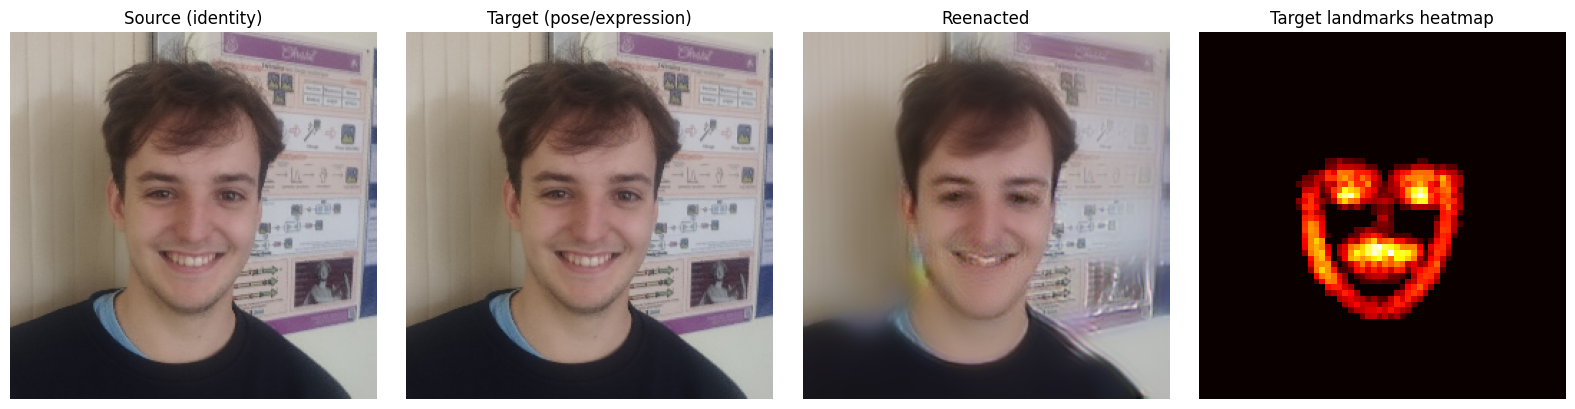

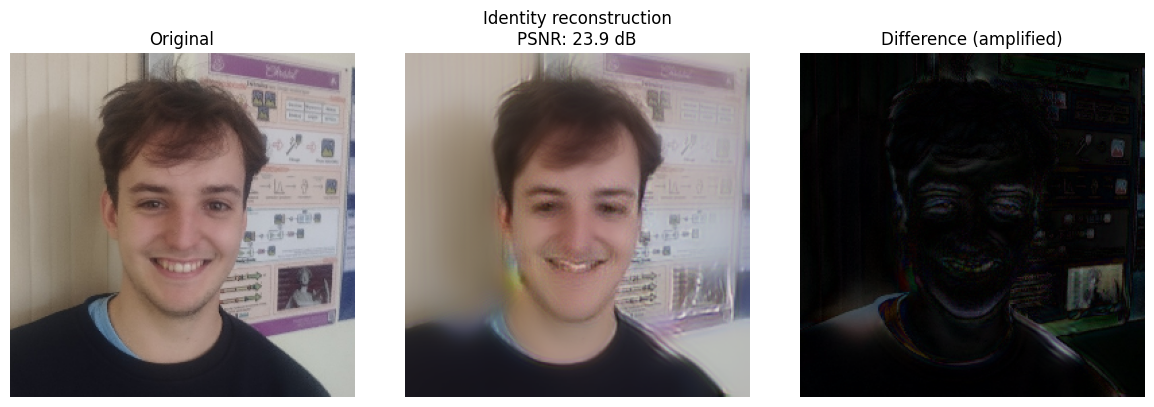

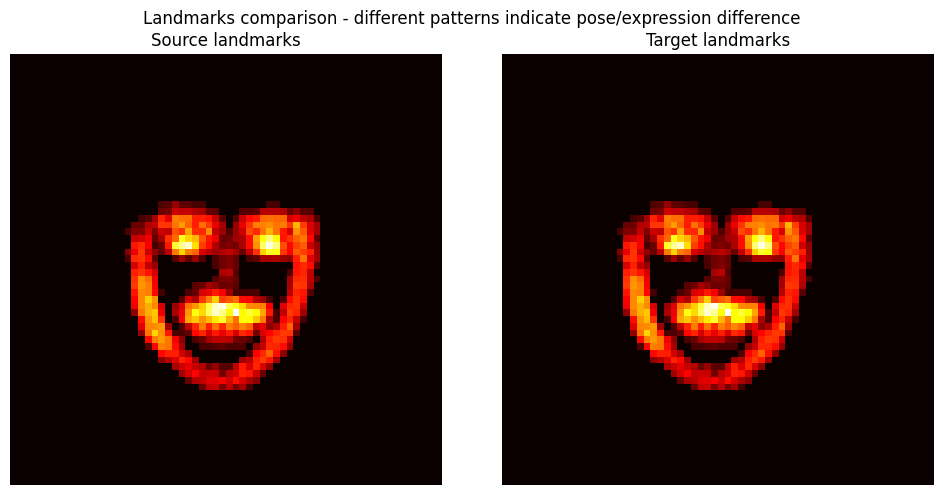

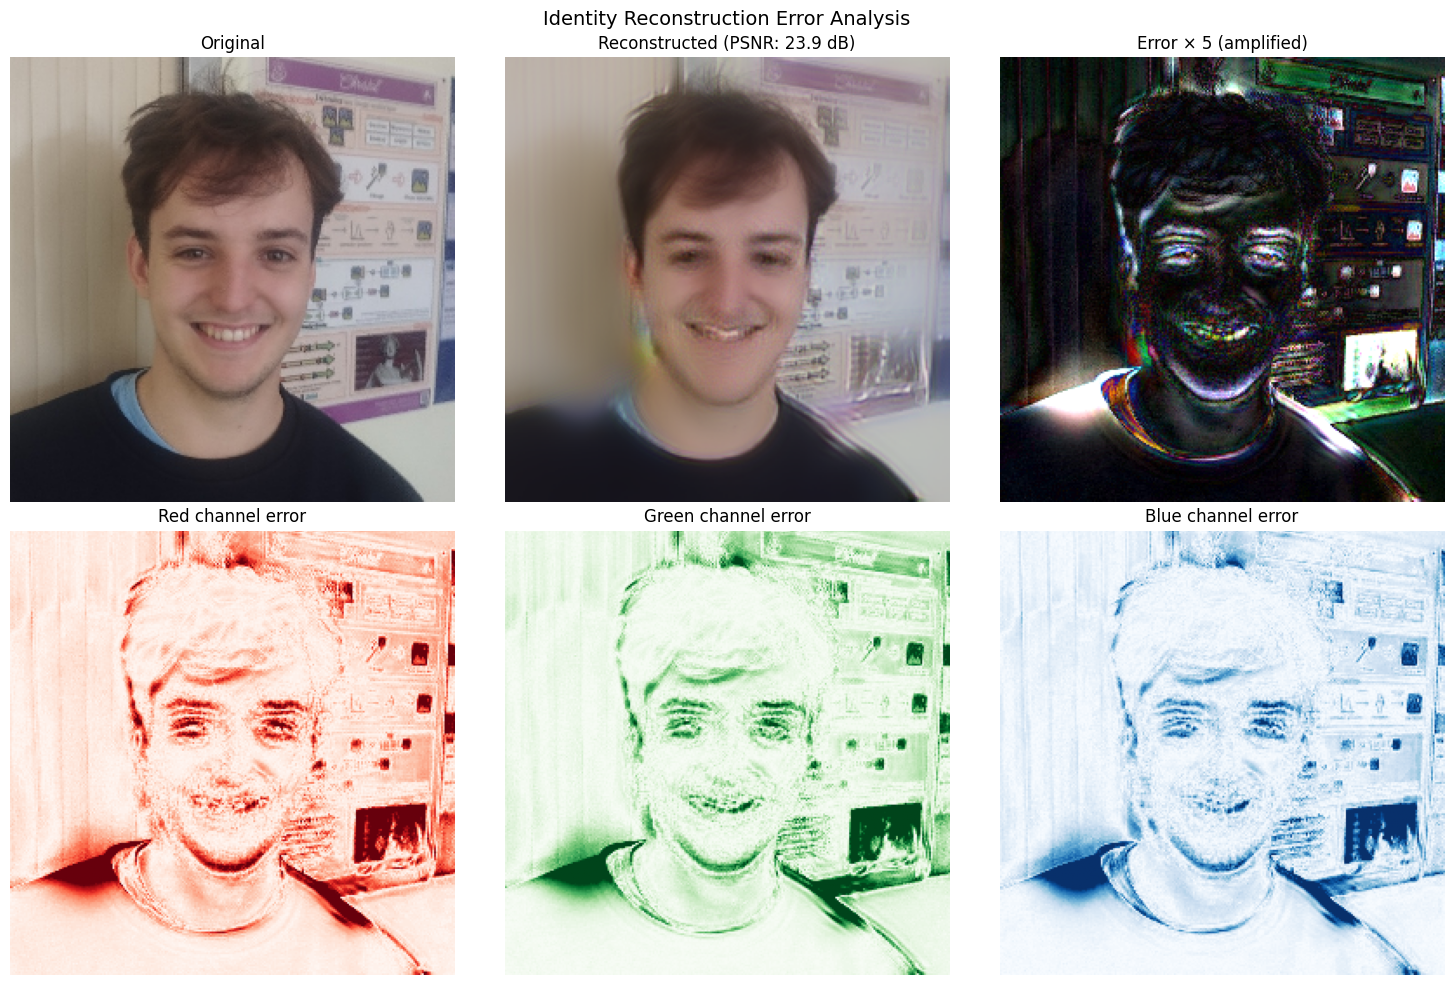

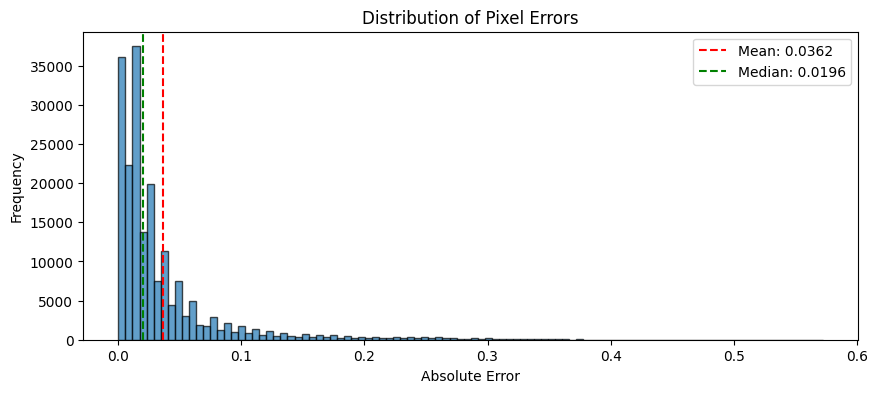

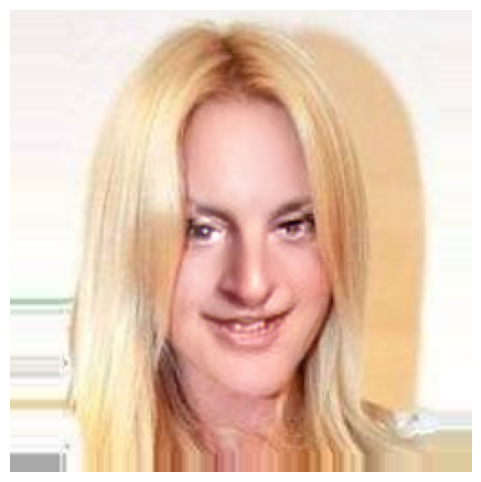

In [10]:
%matplotlib inline


OUT_DIR = Path('outputs')
OUT_DIR.mkdir(exist_ok=True)
src = str(Path('input/0.jpg'))
tgt = str(Path('input/1.jpg'))
out_file = str(OUT_DIR / 'reenact_full_composited.png')


result_bgr, intermediates, src_crop, tgt_crop = run_full_pipeline(src, tgt, out_path=out_file, reenact=True, use_detector=True, device=device,crop_scale=1.5, resolution=256)

print('Saved full result to', out_file)

try:
    img = cv2.cvtColor(result_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6)); plt.axis('off'); plt.imshow(img); plt.show()
except Exception as e:
    print('Could not display image inline:', e)

In [11]:
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
import torch.nn.functional as F


# Load the pre-trained FaceNet model
embedding_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Define preprocessing transformations
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160, 160)),  # FaceNet expects 160x160 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize to [-1, 1]
])

def compute_embedding(image_tensor):
    with torch.no_grad():
        # Preprocess the image
        image_tensor = preprocess(image_tensor.permute(1, 2, 0).cpu().numpy()).unsqueeze(0).to(device)
        # Compute the embedding
        embedding = embedding_model(image_tensor)
        return F.normalize(embedding, p=2, dim=1)  # Normalize the embedding

# Compute embeddings for the source, target, and output images

src_image = cv2.imread(src)
src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
src_tensor = preprocess(src_image).unsqueeze(0).to(device)
src_embedding = compute_embedding(src_tensor[0])

tgt_image = cv2.imread(tgt)
tgt_image = cv2.cvtColor(tgt_image, cv2.COLOR_BGR2RGB)
tgt_tensor = preprocess(tgt_image).unsqueeze(0).to(device)
tgt_embedding = compute_embedding(tgt_tensor[0])
out_embedding = compute_embedding(out_tensor[0])

# Compare embeddings using cosine similarity
src_out_similarity = F.cosine_similarity(src_embedding, out_embedding).item()
tgt_out_similarity = F.cosine_similarity(tgt_embedding, out_embedding).item()

print(f"Cosine similarity between source and output: {src_out_similarity:.4f}")
print(f"Cosine similarity between target and output: {tgt_out_similarity:.4f}")


c:\Users\Arthur\Documents\Github\Face-Swap-M2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cosine similarity between source and output: 0.6629
Cosine similarity between target and output: 0.2323


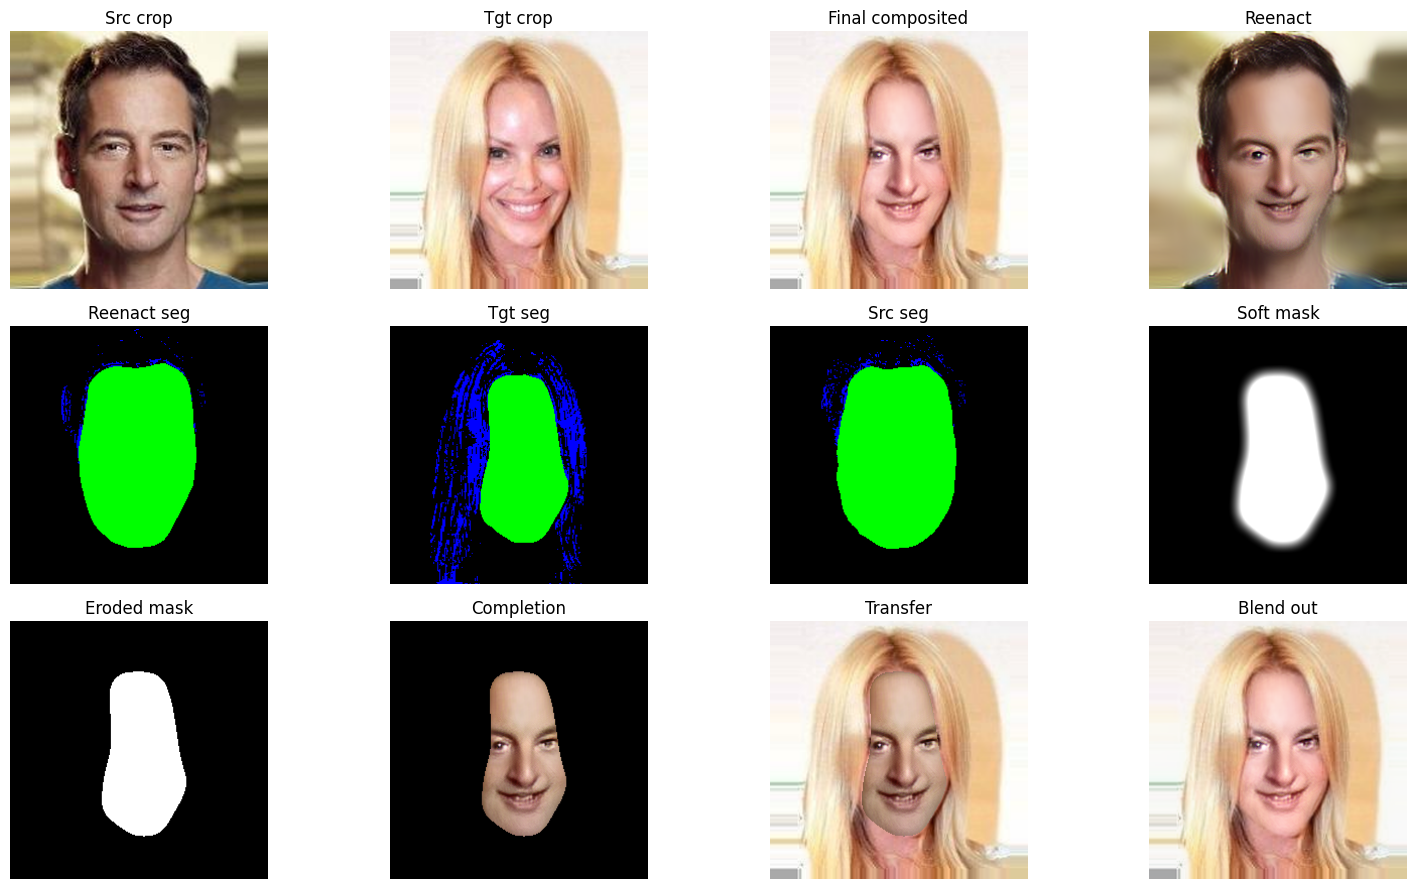

In [12]:
# Cell: Visualize intermediate steps: preprocessing, segmentation, inpainting, blending
import math
from fsgan.utils.img_utils import tensor2bgr

def tensor_to_bgr_uint8(x):
    import numpy as _np
    import torch as _torch
    if isinstance(x, _torch.Tensor):
        t = x.detach().cpu()
        if t.ndim == 4:
            t = t[0]
        # t expected in [-1,1] or [0,1]
        if t.min() >= -1.1 and t.max() <= 1.1:
            return tensor2bgr(t).astype('uint8')
        else:
            arr = (t.numpy().transpose(1,2,0) * 255.0).clip(0,255).astype('uint8')
            return arr[:, :, ::-1]
    else:
        arr = x.copy()
        if arr.dtype != _np.uint8:
            arr = arr.astype('uint8')
        return arr

def seg_to_color(seg_arr):
    import numpy as _np
    h,w = seg_arr.shape
    cmap = _np.array([[0,0,0],[0,255,0],[0,0,255],[255,0,0],[255,255,0]], dtype='uint8')
    out = _np.zeros((h,w,3), dtype='uint8')
    labels = _np.clip(seg_arr, 0, cmap.shape[0]-1)
    for i in range(cmap.shape[0]):
        out[labels==i] = cmap[i]
    return out

# Gather images to display
imgs = []
titles = []
# Preprocessing crops
try:
    imgs.append(src_crop)
    titles.append('Src crop')
except Exception:
    pass
try:
    imgs.append(tgt_crop)
    titles.append('Tgt crop')
except Exception:
    pass
# Reenact result
try:
    imgs.append(result_bgr)
    titles.append('Final composited')
except Exception:
    pass
# Reenactment-only (generator output) if available
if 'reenact_tensor' in intermediates:
    try:
        imgs.append(tensor_to_bgr_uint8(intermediates['reenact_tensor']))
        titles.append('Reenact')
    except Exception:
        pass
# Segmentation maps
if 'reenact_seg' in intermediates:
    s = intermediates['reenact_seg']
    try:
        s_np = s.detach().cpu().numpy() if hasattr(s, 'detach') else s
        if s_np.ndim == 4:
            lab = s_np.argmax(1)[0].astype('int')
        else:
            lab = s_np.astype('int')
        imgs.append(seg_to_color(lab)[:,:,::-1])
        titles.append('Reenact seg')
    except Exception:
        pass
if 'tgt_seg' in intermediates:
    s = intermediates['tgt_seg']
    try:
        s_np = s.detach().cpu().numpy() if hasattr(s, 'detach') else s
        if s_np.ndim == 4:
            lab = s_np.argmax(1)[0].astype('int')
        else:
            lab = s_np.astype('int')
        imgs.append(seg_to_color(lab)[:,:,::-1])
        titles.append('Tgt seg')
    except Exception:
        pass
# Source segmentation (for original source crop) if available
if 'src_seg' in intermediates:
    s = intermediates['src_seg']
    try:
        s_np = s.detach().cpu().numpy() if hasattr(s, 'detach') else s
        if s_np.ndim == 4:
            lab = s_np.argmax(1)[0].astype('int')
        else:
            lab = s_np.astype('int')
        imgs.append(seg_to_color(lab)[:,:,::-1])
        titles.append('Src seg')
    except Exception:
        pass
# Masks: soft and eroded
if 'soft_tgt_mask' in intermediates:
    m = intermediates['soft_tgt_mask']
    try:
        m_np = m.detach().cpu().numpy()[0,0]
        imgs.append((m_np*255).astype('uint8'))
        titles.append('Soft mask')
    except Exception:
        pass
if 'eroded_tgt_mask' in intermediates:
    m = intermediates['eroded_tgt_mask']
    try:
        m_np = m.detach().cpu().numpy()[0,0]
        imgs.append((m_np*255).astype('uint8'))
        titles.append('Eroded mask')
    except Exception:
        pass
# Completion / transfer / blend
for key, label in [('completion','Completion'), ('transfer','Transfer'), ('blend_out','Blend out')]:
    if key in intermediates:
        try:
            imgs.append(tensor_to_bgr_uint8(intermediates[key]))
            titles.append(label)
        except Exception:
            pass

# Plot grid
n = len(imgs)
if n == 0:
    print('No intermediates available to display')
else:
    cols = min(4, n)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(4*cols, 3*rows))
    for i, im in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.axis('off')
        if im.ndim == 2:
            plt.imshow(im, cmap='gray')
        else:
            plt.imshow(im[:,:,::-1])
        plt.title(titles[i])
    plt.tight_layout()
    plt.show()

## Entrainement

In [2]:
#import utils
import dataloader
from torch.utils.data import Dataset, DataLoader
print("Cuda compatible : ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda compatible :  True


c:\Users\Arthur\Documents\Github\Face-Swap-M2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
IMAGE_SIZE = 256
NB_IMAGES = 10

In [4]:
train_dataset, test_dataset, nb_classes = dataloader.make_dataset("../data/Face-Swap-M2-Dataset/dataset/smaller", NB_IMAGES, IMAGE_SIZE, 0.8, crop_faces=False)

Building dataset 



In [5]:

EMBEDDING_SIZE = 128
BATCH_SIZE = 32

EPOCHS = 100

In [6]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
print(f"train samples: {len(train_dataset)}, test samples: {len(test_dataset)}, nb_classes: {nb_classes}")

class_counts = np.bincount([label for _, label in train_dataset])
for cls, count in enumerate(class_counts):
    print(f"train Class {cls}: {count} samples")

class_counts = np.bincount([label for _, label in test_dataset])
for cls, count in enumerate(class_counts):
    print(f"Test Class {cls}: {count} samples")

images, labels = next(iter(train_loader))
images = images.cpu()
labels = labels.cpu().numpy()

n = min(8, images.size(0))
imgs = images[:n]
labs = labels[:n]

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < n:
        img = imgs[i].permute(1, 2, 0).numpy()
        mi, ma = img.min(), img.max()
        img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
        ax.imshow(img_disp)
        ax.set_title(f"label: {labs[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

train samples: 67, test samples: 20, nb_classes: 10
train Class 0: 8 samples
train Class 1: 7 samples
train Class 2: 7 samples
train Class 3: 5 samples
train Class 4: 4 samples
train Class 5: 7 samples
train Class 6: 8 samples
train Class 7: 7 samples
train Class 8: 8 samples
train Class 9: 6 samples
Test Class 0: 2 samples
Test Class 1: 2 samples
Test Class 2: 2 samples
Test Class 3: 2 samples
Test Class 4: 2 samples
Test Class 5: 2 samples
Test Class 6: 2 samples
Test Class 7: 2 samples
Test Class 8: 2 samples
Test Class 9: 2 samples


C:\Users\Arthur\AppData\Local\Temp\ipykernel_20996\1860844808.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [19]:
import random

# Directory to save results
random_swap_dir = OUT_DIR / 'random_swaps'
random_swap_dir.mkdir(exist_ok=True)

# Function to perform face swapping on a pair of images
def swap_and_save(src_img, tgt_img, src_label, tgt_label, idx):
    src_path = random_swap_dir / f'src_{idx}_label_{src_label}.png'
    tgt_path = random_swap_dir / f'tgt_{idx}_label_{tgt_label}.png'
    out_path = random_swap_dir / f'swap_{idx}_src_{src_label}_to_tgt_{tgt_label}.png'

    # Convert tensors to NumPy arrays and scale to [0, 255]
    src_img_np = ((src_img.permute(1, 2, 0).numpy() + 1) * 127.5).clip(0, 255).astype('uint8')
    tgt_img_np = ((tgt_img.permute(1, 2, 0).numpy() + 1) * 127.5).clip(0, 255).astype('uint8')

    # Convert RGB to BGR for OpenCV
    src_img_bgr = cv2.cvtColor(src_img_np, cv2.COLOR_RGB2BGR)
    tgt_img_bgr = cv2.cvtColor(tgt_img_np, cv2.COLOR_RGB2BGR)

    # Save source and target images
    cv2.imwrite(str(src_path), src_img_bgr)
    cv2.imwrite(str(tgt_path), tgt_img_bgr)

    # Run the face swap pipeline
    result_bgr, _, _, _ = run_full_pipeline(
        str(src_path), str(tgt_path), out_path=str(out_path),
        reenact=True, use_detector=True, device=device, crop_scale=1.2, resolution=256
    )

    print(f'Saved face swap result to {out_path}')

# Select random pairs of images from the dataloader
num_pairs = 0  # Number of random pairs to process
for idx in range(num_pairs):
    src_batch, src_labels = next(iter(train_loader))
    tgt_batch, tgt_labels = next(iter(test_loader))

    # Randomly select a source and target image from the batches
    src_idx = random.randint(0, src_batch.size(0) - 1)
    tgt_idx = random.randint(0, tgt_batch.size(0) - 1)

    src_img = src_batch[src_idx].cpu()
    tgt_img = tgt_batch[tgt_idx].cpu()
    src_label = src_labels[src_idx].item()
    tgt_label = tgt_labels[tgt_idx].item()

    # Perform face swap and save the result
    swap_and_save(src_img, tgt_img, src_label, tgt_label, idx)

# Entrainement reenactement

In [20]:
import importlib
import fsgan.criterions.vgg_loss
importlib.reload(fsgan.criterions.vgg_loss)
from fsgan.criterions.vgg_loss import VGGLoss

In [8]:
# Finetuning the Reenactment Model on Custom Dataset
# This follows the FSGAN training approach with perceptual + pixel + adversarial losses

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from fsgan.criterions.vgg_loss import VGGLoss
from fsgan.utils.img_utils import bgr2tensor, create_pyramid, tensor2bgr
from fsgan.utils.landmarks_utils import LandmarksHeatMapDecoder, filter_landmarks

# ============================================================
# Configuration
# ============================================================
FINETUNE_EPOCHS = 1
FINETUNE_LR = 1e-5  # Lower learning rate for finetuning
FINETUNE_BATCH_SIZE = 4
SAVE_EVERY = 10  # Save checkpoint every N epochs

# Loss weights (from FSGAN paper)
WEIGHT_PIXEL = 0.1      # L1 pixel loss
WEIGHT_PERCEPTUAL = 1.0  # VGG perceptual loss (identity + attributes)
WEIGHT_REC = 1.0         # Combined reconstruction weight

# ============================================================
# Load pretrained models
# ============================================================
print("Loading pretrained models for finetuning...")

# Load reenactment generator
reenact_w = ROOT / 'fsgan' / 'weights' / 'nfv_msrunet_256_1_2_reenactment_v2.1.pth'
Gr_finetune, ckpt = load_model(str(reenact_w), 'reenactment', device=device, return_checkpoint=True)
Gr_finetune.train()  # Set to training mode
print(f"Loaded reenactment generator: {ckpt.get('arch', 'unknown')}")

# Load landmarks model (frozen - we don't finetune this)
lms_w = ROOT / 'fsgan' / 'weights' / 'hr18_wflw_landmarks.pth'
L_frozen, _ = load_model(str(lms_w), 'landmarks', device=device, return_checkpoint=True)
L_frozen.eval()
for param in L_frozen.parameters():
    param.requires_grad = False
print("Loaded landmarks model (frozen)")

# Get generator properties
n_local = getattr(Gr_finetune, 'n_local_enhancers', None)
if n_local is None and hasattr(Gr_finetune, 'module'):
    n_local = getattr(Gr_finetune.module, 'n_local_enhancers', None)
n_local = n_local if n_local is not None else 1
n_levels = n_local + 1
print(f"Pyramid levels: {n_levels}")

# ============================================================
# Loss functions
# ============================================================
print("\nInitializing loss functions...")

# Pixel-wise L1 loss
criterion_pixel = nn.L1Loss().to(device)

# Perceptual loss using VGG (identity preservation)
try:
    vgg_id_path = str(ROOT / 'fsgan' / 'weights' / 'vggface2_vgg19_256_1_2_id.pth')
    criterion_id = VGGLoss(vgg_id_path).to(device)
    criterion_id.eval()
    print("Loaded VGG identity loss")
except Exception as e:
    print(f"Could not load VGG identity loss: {e}")
    criterion_id = None

# Attribute loss (optional - uses different VGG weights)
try:
    vgg_attr_path = str(ROOT / 'fsgan' / 'weights' / 'celeba_vgg19_256_2_0_28_attr.pth')
    criterion_attr = VGGLoss(vgg_attr_path).to(device)
    criterion_attr.eval()
    print("Loaded VGG attribute loss")
except Exception as e:
    print(f"Could not load VGG attribute loss: {e}")
    criterion_attr = None

# ============================================================
# Optimizer
# ============================================================
optimizer_G = optim.Adam(Gr_finetune.parameters(), lr=FINETUNE_LR, betas=(0.5, 0.999))
print(f"Optimizer: Adam, LR={FINETUNE_LR}")

# ============================================================
# ImageNet normalization for landmarks model
# ============================================================
imagenet_mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
imagenet_std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

print("\n✓ Finetuning setup complete!")

Loading pretrained models for finetuning...
=> Loading reenactment model: "nfv_msrunet_256_1_2_reenactment_v2.1.pth"...
Loaded reenactment generator: res_unet.MultiScaleResUNet(in_nc=101,out_nc=3,flat_layers=(2,2,2,2),ngf=128)
=> Loading landmarks model: "hr18_wflw_landmarks.pth"...
Loaded reenactment generator: res_unet.MultiScaleResUNet(in_nc=101,out_nc=3,flat_layers=(2,2,2,2),ngf=128)
=> Loading landmarks model: "hr18_wflw_landmarks.pth"...
Loaded landmarks model (frozen)
Pyramid levels: 2

Initializing loss functions...
Loaded landmarks model (frozen)
Pyramid levels: 2

Initializing loss functions...
Loaded VGG identity loss
Loaded VGG identity loss
Loaded VGG attribute loss
Optimizer: Adam, LR=1e-05

✓ Finetuning setup complete!
Loaded VGG attribute loss
Optimizer: Adam, LR=1e-05

✓ Finetuning setup complete!


In [9]:
# Custom Dataset wrapper for reenactment finetuning
# For reenactment training, we need pairs of images from the SAME person
# with different poses/expressions

class ReenactmentPairDataset(Dataset):
    """
    Wraps an existing dataset to create pairs for reenactment training.
    For each sample, we find another sample with the same label (same person)
    to create source-target pairs.
    """
    def __init__(self, base_dataset, resolution=256):
        self.base_dataset = base_dataset
        self.resolution = resolution
        
        # Group samples by label (person identity)
        self.label_to_indices = {}
        for idx in range(len(base_dataset)):
            _, label = base_dataset[idx]
            if isinstance(label, torch.Tensor):
                label = label.item()
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(idx)
        
        # Filter labels with at least 2 samples (needed for pairs)
        self.valid_labels = [l for l, indices in self.label_to_indices.items() if len(indices) >= 2]
        
        # Create list of valid indices (only from labels with 2+ samples)
        self.valid_indices = []
        for label in self.valid_labels:
            self.valid_indices.extend(self.label_to_indices[label])
        
        print(f"ReenactmentPairDataset: {len(self.valid_labels)} identities with 2+ samples")
        print(f"Total valid samples: {len(self.valid_indices)}")
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        # Get source sample
        src_idx = self.valid_indices[idx]
        src_img, src_label = self.base_dataset[src_idx]
        if isinstance(src_label, torch.Tensor):
            src_label = src_label.item()
        
        # Get a different sample from the same person (target)
        same_person_indices = self.label_to_indices[src_label]
        # Pick a random different index
        tgt_idx = src_idx
        while tgt_idx == src_idx:
            tgt_idx = same_person_indices[np.random.randint(len(same_person_indices))]
        
        tgt_img, _ = self.base_dataset[tgt_idx]
        
        return src_img, tgt_img, src_label

# Create paired dataset from your training data
print("Creating paired dataset for reenactment finetuning...")
finetune_dataset = ReenactmentPairDataset(train_dataset, resolution=IMAGE_SIZE)

# Create dataloader
finetune_loader = DataLoader(
    finetune_dataset, 
    batch_size=FINETUNE_BATCH_SIZE, 
    shuffle=True,
    num_workers=0,  # Set to 0 for debugging, increase for speed
    drop_last=True
)

print(f"Finetune dataloader: {len(finetune_loader)} batches of {FINETUNE_BATCH_SIZE}")

Creating paired dataset for reenactment finetuning...
ReenactmentPairDataset: 10 identities with 2+ samples
Total valid samples: 67
Finetune dataloader: 16 batches of 4


In [10]:
# Helper function to prepare inputs for the reenactment generator
def prepare_reenactment_input(src_batch, tgt_batch, L_model, n_pyramid_levels, device):
    """
    Prepare source image pyramid with target landmarks context.
    
    Args:
        src_batch: Source images tensor (B, 3, H, W) in [-1, 1] or [0, 1]
        tgt_batch: Target images tensor (B, 3, H, W) in [-1, 1] or [0, 1]
        L_model: Landmarks model (frozen)
        n_pyramid_levels: Number of pyramid levels
        device: torch device
    
    Returns:
        input_list: List of (src_image + tgt_landmarks) tensors for each pyramid level
    """
    batch_size = src_batch.shape[0]
    
    # Ensure images are in [-1, 1] range for generator
    if src_batch.min() >= 0:
        src_normalized = src_batch * 2 - 1  # [0,1] -> [-1,1]
    else:
        src_normalized = src_batch
    
    if tgt_batch.min() >= 0:
        tgt_normalized = tgt_batch * 2 - 1
    else:
        tgt_normalized = tgt_batch
    
    # Prepare target for landmarks model (ImageNet normalization)
    # First convert from [-1,1] to [0,1], then apply ImageNet norm
    tgt_01 = (tgt_normalized + 1) / 2  # [-1,1] -> [0,1]
    tgt_for_lms = (tgt_01 - imagenet_mean) / imagenet_std
    
    # Get landmarks from target
    with torch.no_grad():
        tgt_landmarks = L_model(tgt_for_lms)
        tgt_landmarks = filter_landmarks(tgt_landmarks)
    
    # Build source pyramid
    src_pyd = create_pyramid(src_normalized, n_pyramid_levels)
    
    # Build input list: source image + target landmarks at each level
    input_list = []
    for p in range(len(src_pyd)):
        pyd_h, pyd_w = src_pyd[p].shape[2:]
        context = F.interpolate(tgt_landmarks, size=(pyd_h, pyd_w), mode='bilinear', align_corners=False)
        context = filter_landmarks(context)
        inp = torch.cat((src_pyd[p], context), dim=1)
        input_list.append(inp)
    
    return input_list, tgt_normalized

print("✓ Helper functions defined")

✓ Helper functions defined


In [11]:
# ============================================================
# FINETUNING TRAINING LOOP
# ============================================================

def finetune_reenactment(model, dataloader, optimizer, epochs, save_dir='models/finetuned'):
    """
    Finetune the reenactment generator on paired face data.
    
    The training objective follows FSGAN:
    - Source image + Target landmarks → should produce Target image
    - Loss = pixel L1 + perceptual (VGG identity + attributes)
    """
    save_path = Path(save_dir)
    save_path.mkdir(parents=True, exist_ok=True)
    
    model.train()
    history = {'loss': [], 'loss_pixel': [], 'loss_id': [], 'loss_attr': []}
    
    print("=" * 60)
    print("STARTING FINETUNING")
    print("=" * 60)
    print(f"Epochs: {epochs}")
    print(f"Batches per epoch: {len(dataloader)}")
    print(f"Save directory: {save_path}")
    print("=" * 60)
    
    model.train()

    for epoch in range(epochs):
        epoch_losses = {'total': 0, 'pixel': 0, 'id': 0, 'attr': 0}
        n_batches = 0
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for src_img, tgt_img, labels in pbar:
            src_img = src_img.to(device)
            tgt_img = tgt_img.to(device)
            
            # Prepare inputs
            input_list, tgt_normalized = prepare_reenactment_input(
                src_img, tgt_img, L_frozen, n_levels, device
            )
            
            # Forward pass
            output = model(input_list)
            if isinstance(output, (list, tuple)):
                pred = output[-1]
            else:
                pred = output
            
            # Compute losses
            # 1. Pixel-wise L1 loss
            loss_pixel = criterion_pixel(pred, tgt_normalized)
            
            # 2. Perceptual identity loss
            if criterion_id is not None:
                loss_id = criterion_id(pred, tgt_normalized)
            else:
                loss_id = torch.tensor(0.0, device=device)
            
            # 3. Attribute loss
            if criterion_attr is not None:
                loss_attr = criterion_attr(pred, tgt_normalized)
            else:
                loss_attr = torch.tensor(0.0, device=device)
            
            # Combined reconstruction loss (following FSGAN Eq. 3)
            loss_rec = WEIGHT_PIXEL * loss_pixel + 0.5 * loss_id + 0.5 * loss_attr
            loss_total = WEIGHT_REC * loss_rec
            
            # Backward pass
            optimizer.zero_grad()
            loss_total.backward()
            optimizer.step()
            
            # Track losses
            epoch_losses['total'] += loss_total.item()
            epoch_losses['pixel'] += loss_pixel.item()
            epoch_losses['id'] += loss_id.item() if criterion_id else 0
            epoch_losses['attr'] += loss_attr.item() if criterion_attr else 0
            n_batches += 1
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f"{loss_total.item():.4f}",
                'pix': f"{loss_pixel.item():.4f}",
                'id': f"{loss_id.item():.4f}" if criterion_id else "N/A"
            })
        
        # Epoch summary
        avg_loss = epoch_losses['total'] / n_batches
        avg_pixel = epoch_losses['pixel'] / n_batches
        avg_id = epoch_losses['id'] / n_batches
        avg_attr = epoch_losses['attr'] / n_batches
        
        history['loss'].append(avg_loss)
        history['loss_pixel'].append(avg_pixel)
        history['loss_id'].append(avg_id)
        history['loss_attr'].append(avg_attr)
        
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Pixel={avg_pixel:.4f}, ID={avg_id:.4f}, Attr={avg_attr:.4f}")
        
        # Save checkpoint
        if (epoch + 1) % SAVE_EVERY == 0 or epoch == epochs - 1:
            ckpt_path = save_path / f'reenact_finetuned_epoch{epoch+1}.pth'
            torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'arch': ckpt.get('arch', 'unknown'),
                'history': history,
            }, ckpt_path)
            print(f"  → Saved checkpoint: {ckpt_path}")
    
    print("\n" + "=" * 60)
    print("FINETUNING COMPLETE")
    print("=" * 60)
    
    return history

print("✓ Training function defined")

✓ Training function defined


In [12]:
# ============================================================
# RUN FINETUNING
# ============================================================

# Make sure we have enough data
if len(finetune_dataset) < FINETUNE_BATCH_SIZE:
    print(f"⚠ Warning: Not enough paired samples ({len(finetune_dataset)}) for batch size {FINETUNE_BATCH_SIZE}")
    print("  Consider using more images per identity or reducing batch size")
else:
    print(f"Ready to finetune with {len(finetune_dataset)} paired samples")

    # Run finetuning
    history = finetune_reenactment(
        model=Gr_finetune,
        dataloader=finetune_loader,
        optimizer=optimizer_G,
        epochs=75,
        save_dir=str(OUT_DIR / 'finetuned_models')
    )

Ready to finetune with 67 paired samples
STARTING FINETUNING
Epochs: 75
Batches per epoch: 16
Save directory: outputs\finetuned_models


Epoch 1/75: 100%|██████████| 16/16 [06:04<00:00, 22.77s/it, loss=0.1259, pix=0.2508, id=0.1667]


Epoch 1: Loss=0.1413, Pixel=0.3458, ID=0.1769, Attr=0.0365


Epoch 2/75: 100%|██████████| 16/16 [06:02<00:00, 22.63s/it, loss=0.1261, pix=0.2649, id=0.1651]


Epoch 2: Loss=0.1333, Pixel=0.3012, ID=0.1709, Attr=0.0354


Epoch 3/75: 100%|██████████| 16/16 [06:07<00:00, 23.00s/it, loss=0.1321, pix=0.2762, id=0.1733]


Epoch 3: Loss=0.1302, Pixel=0.2825, ID=0.1687, Attr=0.0351


Epoch 4/75: 100%|██████████| 16/16 [06:07<00:00, 22.98s/it, loss=0.1394, pix=0.3060, id=0.1805]


Epoch 4: Loss=0.1292, Pixel=0.2728, ID=0.1687, Attr=0.0351


Epoch 5/75: 100%|██████████| 16/16 [06:02<00:00, 22.64s/it, loss=0.1280, pix=0.2678, id=0.1673]


Epoch 5: Loss=0.1337, Pixel=0.2993, ID=0.1719, Attr=0.0356


Epoch 6/75: 100%|██████████| 16/16 [06:05<00:00, 22.83s/it, loss=0.1276, pix=0.2583, id=0.1682]


Epoch 6: Loss=0.1285, Pixel=0.2712, ID=0.1675, Attr=0.0351


Epoch 7/75: 100%|██████████| 16/16 [06:00<00:00, 22.54s/it, loss=0.1260, pix=0.2692, id=0.1637]


Epoch 7: Loss=0.1258, Pixel=0.2587, ID=0.1652, Attr=0.0347


Epoch 8/75: 100%|██████████| 16/16 [06:02<00:00, 22.66s/it, loss=0.1315, pix=0.2887, id=0.1695]


Epoch 8: Loss=0.1274, Pixel=0.2668, ID=0.1665, Attr=0.0349


Epoch 9/75: 100%|██████████| 16/16 [06:01<00:00, 22.62s/it, loss=0.1387, pix=0.2981, id=0.1803]


Epoch 9: Loss=0.1268, Pixel=0.2618, ID=0.1663, Attr=0.0349


Epoch 10/75: 100%|██████████| 16/16 [06:08<00:00, 23.02s/it, loss=0.1245, pix=0.2729, id=0.1606]



Epoch 10: Loss=0.1238, Pixel=0.2466, ID=0.1638, Attr=0.0345
  → Saved checkpoint: outputs\finetuned_models\reenact_finetuned_epoch10.pth
  → Saved checkpoint: outputs\finetuned_models\reenact_finetuned_epoch10.pth


Epoch 11/75: 100%|██████████| 16/16 [05:22<00:00, 20.18s/it, loss=0.1153, pix=0.2117, id=0.1548]


Epoch 11: Loss=0.1211, Pixel=0.2365, ID=0.1608, Attr=0.0342


Epoch 12/75: 100%|██████████| 16/16 [05:20<00:00, 20.00s/it, loss=0.1190, pix=0.2219, id=0.1591]


Epoch 12: Loss=0.1221, Pixel=0.2404, ID=0.1619, Attr=0.0341


Epoch 13/75: 100%|██████████| 16/16 [05:22<00:00, 20.16s/it, loss=0.1238, pix=0.2449, id=0.1642]


Epoch 13: Loss=0.1228, Pixel=0.2406, ID=0.1633, Attr=0.0342


Epoch 14/75: 100%|██████████| 16/16 [05:23<00:00, 20.21s/it, loss=0.1342, pix=0.2681, id=0.1775]


Epoch 14: Loss=0.1229, Pixel=0.2392, ID=0.1637, Attr=0.0344


Epoch 15/75: 100%|██████████| 16/16 [05:19<00:00, 19.98s/it, loss=0.1188, pix=0.2295, id=0.1580]


Epoch 15: Loss=0.1215, Pixel=0.2349, ID=0.1619, Attr=0.0341


Epoch 16/75: 100%|██████████| 16/16 [05:21<00:00, 20.10s/it, loss=0.1188, pix=0.2127, id=0.1609]


Epoch 16: Loss=0.1193, Pixel=0.2268, ID=0.1595, Attr=0.0338


Epoch 17/75: 100%|██████████| 16/16 [05:22<00:00, 20.13s/it, loss=0.1126, pix=0.1850, id=0.1552]


Epoch 17: Loss=0.1209, Pixel=0.2319, ID=0.1613, Attr=0.0342


Epoch 18/75: 100%|██████████| 16/16 [05:23<00:00, 20.24s/it, loss=0.1336, pix=0.2882, id=0.1744]


Epoch 18: Loss=0.1225, Pixel=0.2400, ID=0.1628, Attr=0.0343


Epoch 19/75: 100%|██████████| 16/16 [05:19<00:00, 19.99s/it, loss=0.1148, pix=0.2120, id=0.1541]


Epoch 19: Loss=0.1212, Pixel=0.2308, ID=0.1618, Attr=0.0344


Epoch 20/75: 100%|██████████| 16/16 [05:20<00:00, 20.01s/it, loss=0.1083, pix=0.1893, id=0.1470]



Epoch 20: Loss=0.1194, Pixel=0.2239, ID=0.1600, Attr=0.0339
  → Saved checkpoint: outputs\finetuned_models\reenact_finetuned_epoch20.pth
  → Saved checkpoint: outputs\finetuned_models\reenact_finetuned_epoch20.pth


Epoch 21/75: 100%|██████████| 16/16 [05:22<00:00, 20.18s/it, loss=0.1295, pix=0.2818, id=0.1676]


Epoch 21: Loss=0.1185, Pixel=0.2242, ID=0.1585, Attr=0.0336


Epoch 22/75:  94%|█████████▍| 15/16 [7:18:45<29:15, 1755.04s/it, loss=0.1092, pix=0.1827, id=0.1494]  



KeyboardInterrupt: 

In [13]:
# ============================================================
# VISUALIZE TRAINING PROGRESS
# ============================================================

if 'history' in dir() and history:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Total loss
    axes[0].plot(history['loss'], 'b-', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Total Loss')
    axes[0].set_title('Total Loss')
    axes[0].grid(True, alpha=0.3)
    
    # Pixel loss
    axes[1].plot(history['loss_pixel'], 'g-', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Pixel L1 Loss')
    axes[1].set_title('Pixel-wise Loss')
    axes[1].grid(True, alpha=0.3)
    
    # Perceptual losses
    axes[2].plot(history['loss_id'], 'r-', linewidth=2, label='Identity')
    axes[2].plot(history['loss_attr'], 'm-', linewidth=2, label='Attribute')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Perceptual Loss')
    axes[2].set_title('Perceptual Losses')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(str(OUT_DIR / 'finetuning_curves.png'), dpi=150)
    plt.show()
    
    print(f"Final losses - Total: {history['loss'][-1]:.4f}, Pixel: {history['loss_pixel'][-1]:.4f}")
else:
    print("No training history available yet. Run the finetuning cell first.")

No training history available yet. Run the finetuning cell first.


Creating test dataset...
ReenactmentPairDataset: 10 identities with 2+ samples
Total valid samples: 20
✓ Test dataset: 20 paired samples
Saved figure to: outputs\finetuned_test_results.png
Saved figure to: outputs\finetuned_test_results.png


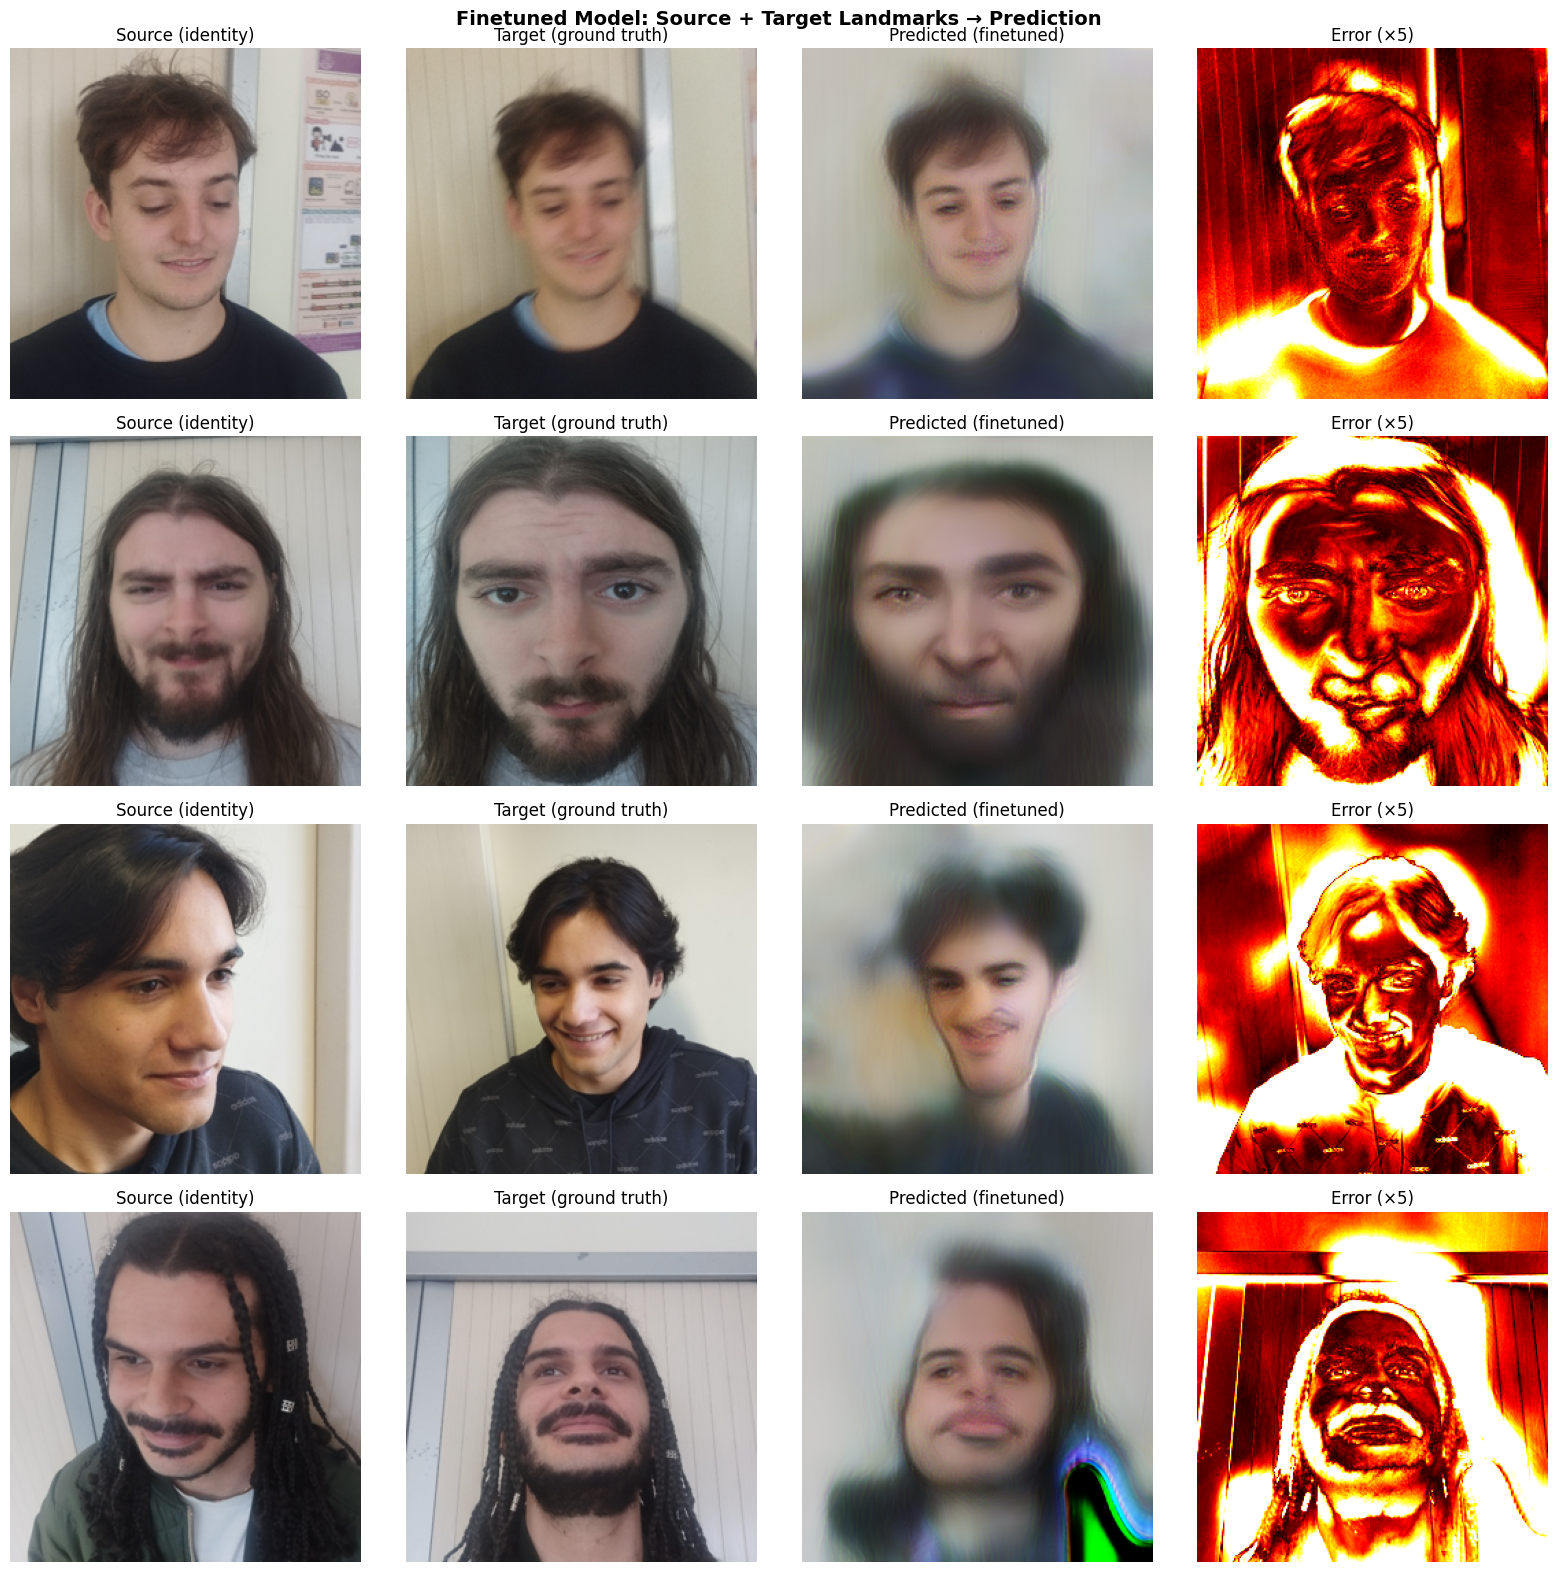


TEST METRICS
  PSNR: 14.44 dB
  MSE:  2339.86
  MAE:  31.84

DETAILED SAMPLE VIEW


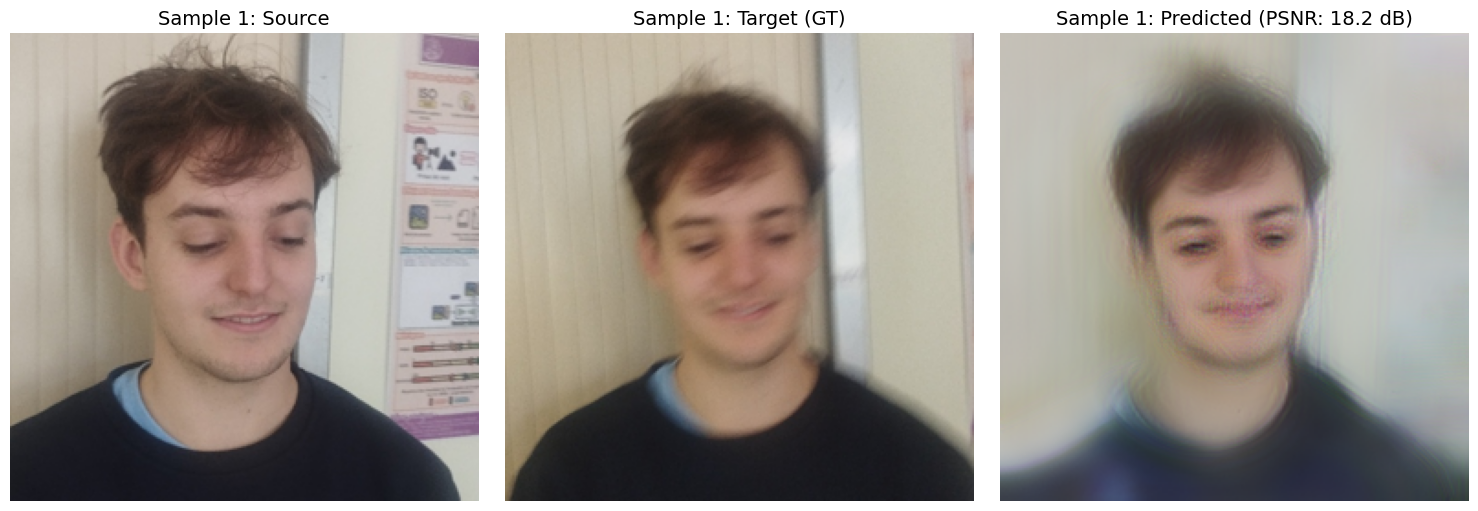

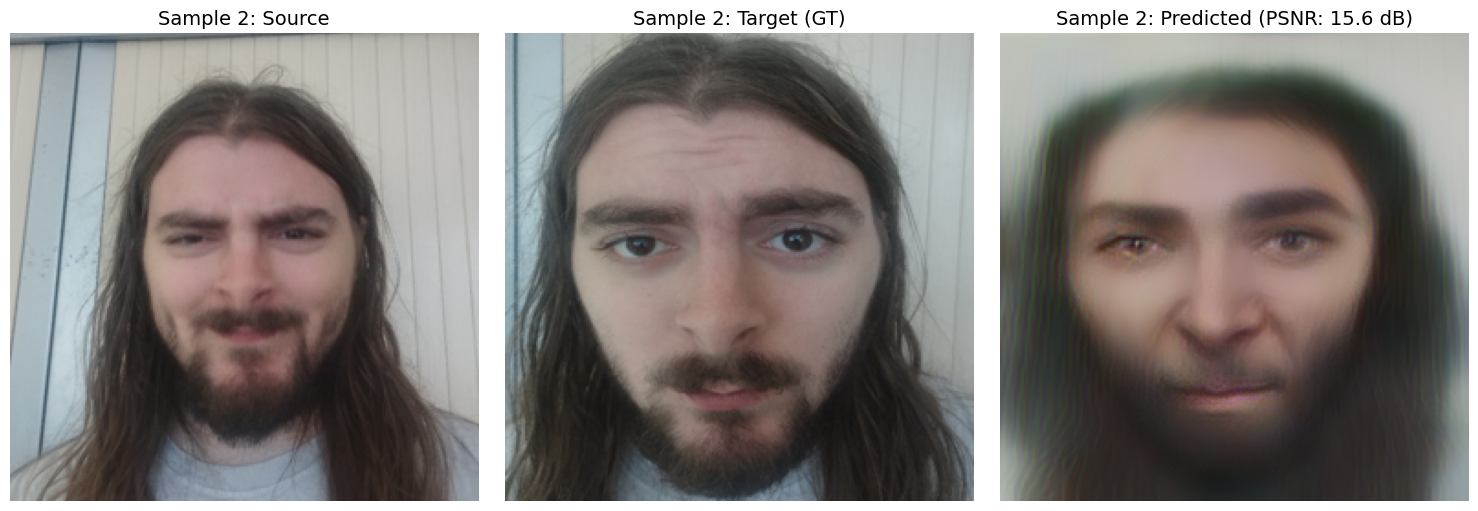

In [17]:
# ============================================================
# TEST FINETUNED MODEL
# ============================================================
%matplotlib inline

def test_finetuned_model(model, test_loader, L_model, n_levels, num_samples=4, save_path=None):
    """Visualize results from finetuned model."""
    model.eval()
    
    # Get a batch
    src_batch, tgt_batch, labels = next(iter(test_loader))
    src_batch = src_batch[:num_samples].to(device)
    tgt_batch = tgt_batch[:num_samples].to(device)
    
    # Prepare inputs
    input_list, tgt_normalized = prepare_reenactment_input(
        src_batch, tgt_batch, L_model, n_levels, device
    )
    
    # Forward pass
    with torch.no_grad():
        output = model(input_list)
        if isinstance(output, (list, tuple)):
            pred = output[-1]
        else:
            pred = output
    
    # Convert to numpy for visualization
    src_np = ((src_batch.cpu().numpy().transpose(0, 2, 3, 1) + 1) / 2 * 255).clip(0, 255).astype('uint8')
    tgt_np = ((tgt_batch.cpu().numpy().transpose(0, 2, 3, 1) + 1) / 2 * 255).clip(0, 255).astype('uint8')
    pred_np = ((pred.cpu().numpy().transpose(0, 2, 3, 1) + 1) / 2 * 255).clip(0, 255).astype('uint8')
    
    # ============================================================
    # VISUALIZATION
    # ============================================================
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        # Source image
        axes[i, 0].imshow(src_np[i])
        axes[i, 0].set_title('Source (identity)', fontsize=12)
        axes[i, 0].axis('off')
        
        # Target image (ground truth)
        axes[i, 1].imshow(tgt_np[i])
        axes[i, 1].set_title('Target (ground truth)', fontsize=12)
        axes[i, 1].axis('off')
        
        # Predicted image
        axes[i, 2].imshow(pred_np[i])
        axes[i, 2].set_title('Predicted (finetuned)', fontsize=12)
        axes[i, 2].axis('off')
        
        # Difference heatmap
        diff = np.abs(tgt_np[i].astype(float) - pred_np[i].astype(float)) / 255.0
        im = axes[i, 3].imshow(diff.mean(axis=2) * 5, cmap='hot', vmin=0, vmax=1)
        axes[i, 3].set_title('Error (×5)', fontsize=12)
        axes[i, 3].axis('off')
    
    plt.suptitle('Finetuned Model: Source + Target Landmarks → Prediction', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to: {save_path}")
    
    # Display inline
    from IPython.display import display
    display(fig)
    plt.close(fig)
    
    # ============================================================
    # METRICS
    # ============================================================
    mse = np.mean((tgt_np.astype(float) - pred_np.astype(float)) ** 2)
    psnr = 10 * np.log10(255**2 / (mse + 1e-10))
    mae = np.mean(np.abs(tgt_np.astype(float) - pred_np.astype(float)))
    
    print(f"\n{'='*50}")
    print(f"TEST METRICS")
    print(f"{'='*50}")
    print(f"  PSNR: {psnr:.2f} dB")
    print(f"  MSE:  {mse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"{'='*50}")
    
    model.train()
    return psnr, pred_np, src_np, tgt_np

# ============================================================
# RUN TEST
# ============================================================
print("Creating test dataset...")

if 'test_dataset' in dir() and test_dataset is not None:
    test_paired = ReenactmentPairDataset(test_dataset, resolution=IMAGE_SIZE)
    
    if len(test_paired) >= FINETUNE_BATCH_SIZE:
        test_paired_loader = DataLoader(test_paired, batch_size=FINETUNE_BATCH_SIZE, shuffle=True)
        print(f"✓ Test dataset: {len(test_paired)} paired samples")
        
        # Test the finetuned model
        test_psnr, pred_images, src_images, tgt_images = test_finetuned_model(
            Gr_finetune, 
            test_paired_loader, 
            L_frozen, 
            n_levels,
            num_samples=min(4, len(test_paired)),
            save_path=str(OUT_DIR / 'finetuned_test_results.png')
        )
        
        # ============================================================
        # ADDITIONAL VISUALIZATION: Individual samples with larger view
        # ============================================================
        print("\n" + "="*50)
        print("DETAILED SAMPLE VIEW")
        print("="*50)
        
        from IPython.display import display
        
        for i in range(min(2, len(pred_images))):
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(src_images[i])
            axes[0].set_title(f'Sample {i+1}: Source', fontsize=14)
            axes[0].axis('off')
            
            axes[1].imshow(tgt_images[i])
            axes[1].set_title(f'Sample {i+1}: Target (GT)', fontsize=14)
            axes[1].axis('off')
            
            axes[2].imshow(pred_images[i])
            # Compute per-sample PSNR
            sample_mse = np.mean((tgt_images[i].astype(float) - pred_images[i].astype(float)) ** 2)
            sample_psnr = 10 * np.log10(255**2 / (sample_mse + 1e-10))
            axes[2].set_title(f'Sample {i+1}: Predicted (PSNR: {sample_psnr:.1f} dB)', fontsize=14)
            axes[2].axis('off')
            
            plt.tight_layout()
            display(fig)
            plt.close(fig)
    else:
        print(f"⚠ Not enough test samples ({len(test_paired)}) for batch size {FINETUNE_BATCH_SIZE}")
        print("  Try reducing FINETUNE_BATCH_SIZE or adding more images per identity")
else:
    print("⚠ No test dataset available. Make sure to run the dataset loading cells first.")

In [34]:
# ============================================================
# LOAD AND USE FINETUNED MODEL
# ============================================================

def load_finetuned_model(checkpoint_path, device):
    """Load a finetuned checkpoint."""
    print(f"Loading finetuned model from: {checkpoint_path}")
    
    ckpt = torch.load(checkpoint_path, map_location=device)
    
    # Recreate model architecture
    from fsgan.utils.obj_factory import obj_factory
    arch = ckpt.get('arch', 'res_unet.MultiScaleResUNet(in_nc=101,out_nc=3)')
    model = obj_factory(arch).to(device)
    model.load_state_dict(ckpt['state_dict'])
    model.eval()
    
    print(f"Loaded epoch {ckpt.get('epoch', '?')}")
    if 'history' in ckpt:
        print(f"Final training loss: {ckpt['history']['loss'][-1]:.4f}")
    
    return model

# Example: Load the best/latest finetuned model
finetuned_dir = OUT_DIR / 'finetuned_models'
if finetuned_dir.exists():
    ckpts = sorted(finetuned_dir.glob('*.pth'))
    if ckpts:
        latest_ckpt = ckpts[-1]
        print(f"Found {len(ckpts)} checkpoints. Latest: {latest_ckpt.name}")
        # Uncomment to load:
        # Gr_finetuned = load_finetuned_model(str(latest_ckpt), device)
    else:
        print("No checkpoints found yet. Run finetuning first.")
else:
    print("Finetuned models directory doesn't exist yet. Run finetuning first.")

Found 1 checkpoints. Latest: reenact_finetuned_epoch1.pth
